In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
%matplotlib inline
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sb  
sb.set_style('darkgrid')
from scipy import stats
from statsmodels.graphics.api import qqplot

In [3]:
daily_data = pd.read_csv('./exchangeratedata/daily_rates.csv', skiprows=3, header=0)
monthly_data = pd.read_csv('./exchangeratedata/monthly_rates.csv', skiprows=11, header=0)

In [4]:
daily_data['datetime'] = pd.to_datetime(daily_data['DATE'])
daily_data['dayofweek'] = daily_data['datetime'].apply(lambda row: row.dayofweek)
weekly_data = daily_data[daily_data['dayofweek'] == 4]

In [12]:
weekly_data.dtypes

DATE                 object
XUDLERS             float64
XUDLUSS             float64
datetime     datetime64[ns]
dayofweek             int64
dtype: object

## Univariate Model

In [50]:
UK_US = pd.DataFrame()
UK_US['UK_US']=weekly_data['XUDLUSS']
UK_US = UK_US.set_index(weekly_data['datetime'].values) # index has to be the variable depicting date-time information

UK_EU = pd.DataFrame()
UK_EU['UK_EU']=weekly_data['XUDLERS']
UK_EU.set_index(weekly_data['datetime'].values)

# dates = pd.DatetimeIndex(UK_US.index)
# dates[:'2000-03-10']
ts = UK_US['UK_US']

In [44]:
ts['2000-01-07']

1.6372

### Checking stationarity of time series

Can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean
- constant variance
- an autocovariance that does not depend on time

Determine stationarity using 
1. the Dickey-Fuller Test: the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
2. Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

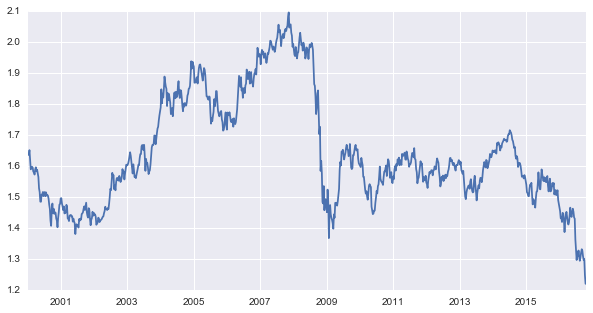

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(UK_US['UK_US'])

In [47]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


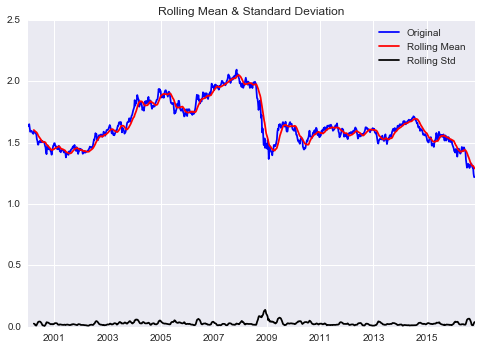

Results of Dickey-Fuller Test:
Test Statistic                  -1.020120
p-value                          0.745855
#Lags Used                       3.000000
Number of Observations Used    848.000000
Critical Value (5%)             -2.864954
Critical Value (1%)             -3.438085
Critical Value (10%)            -2.568588
dtype: float64


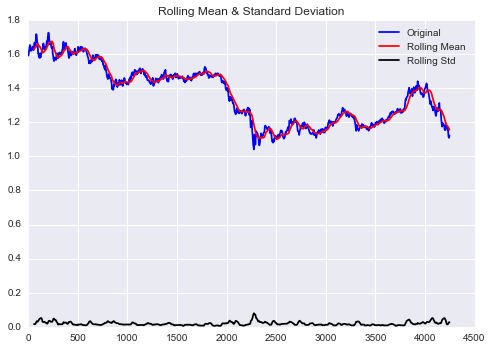

Results of Dickey-Fuller Test:
Test Statistic                  -1.295231
p-value                          0.631351
#Lags Used                       2.000000
Number of Observations Used    849.000000
Critical Value (5%)             -2.864950
Critical Value (1%)             -3.438076
Critical Value (10%)            -2.568586
dtype: float64


In [51]:
test_stationarity(UK_US['UK_US'])
test_stationarity(UK_EU['UK_EU'])

For both series, the test statistic is more than the critical values so the series are not stationary. Note that the signed values should be compared and not the absolute values.

### Make the time series stationary

There are 2 major reasons behind non-stationaruty of a TS:
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

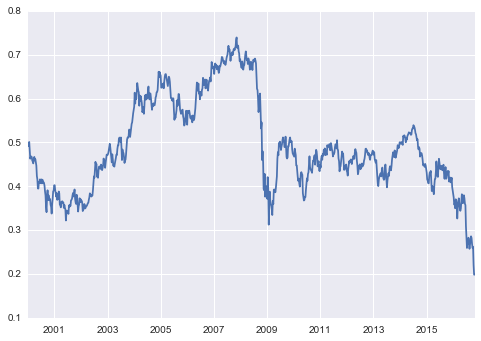

In [181]:
ts = UK_US['UK_US']
ts_log = np.log(UK_US['UK_US'])
plt.plot(ts_log)

### 1. Subtract 3 month moving average

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  if __name__ == '__main__':


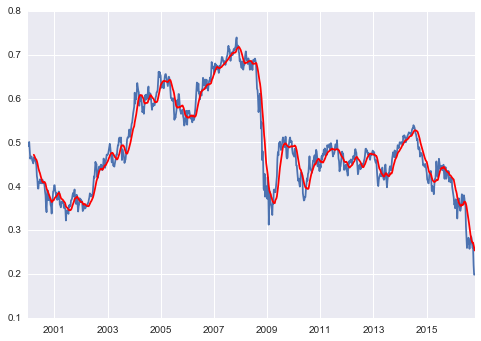

In [111]:
moving_avg = pd.rolling_mean(ts_log,12)
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


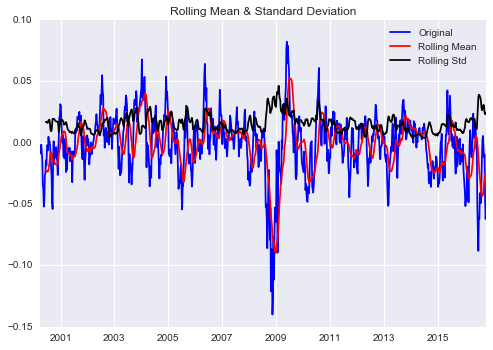

Results of Dickey-Fuller Test:
Test Statistic                  -5.109795
p-value                          0.000013
#Lags Used                      11.000000
Number of Observations Used    829.000000
Critical Value (5%)             -2.865033
Critical Value (1%)             -3.438263
Critical Value (10%)            -2.568630
dtype: float64


In [112]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

The test statistic is smaller than the 1% critical value so with 99% confidence we can say that the series is stationary

### 2. Exponentially weighted moving average

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


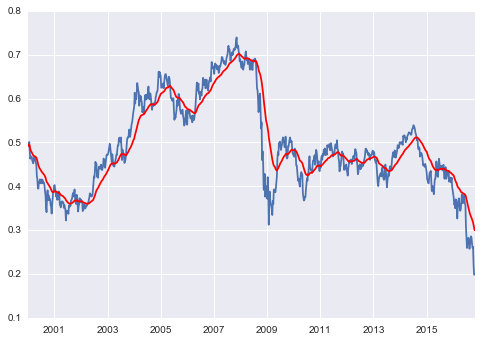

In [114]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


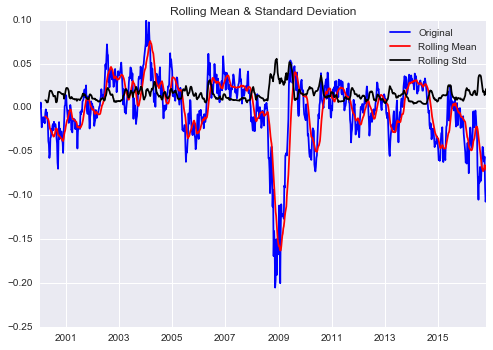

Results of Dickey-Fuller Test:
Test Statistic                  -3.817219
p-value                          0.002736
#Lags Used                       9.000000
Number of Observations Used    842.000000
Critical Value (5%)             -2.864979
Critical Value (1%)             -3.438140
Critical Value (10%)            -2.568601
dtype: float64


In [115]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This also results in a test statistic which is smaller than the 1% critical value

### 3. Differencing

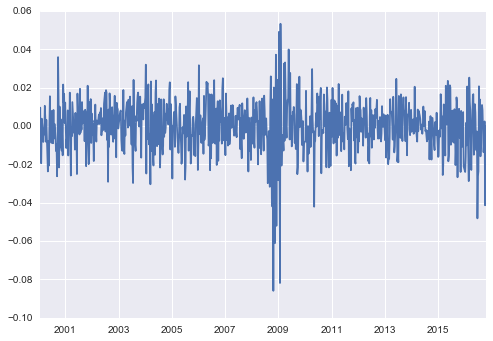

In [180]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
ts_diff = UK_US['UK_US'] - UK_US['UK_US'].shift()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


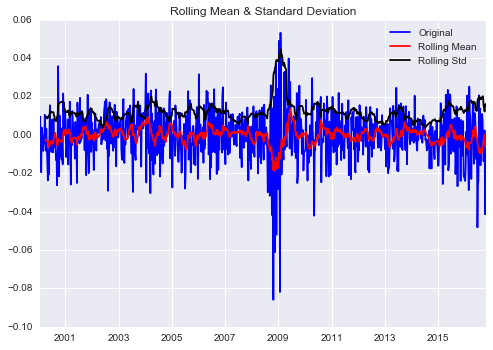

Results of Dickey-Fuller Test:
Test Statistic                -8.990065e+00
p-value                        6.930526e-15
#Lags Used                     8.000000e+00
Number of Observations Used    8.420000e+02
Critical Value (5%)           -2.864979e+00
Critical Value (1%)           -3.438140e+00
Critical Value (10%)          -2.568601e+00
dtype: float64


In [119]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

The test statistic is much lower than the 1% critical value (-16 comared to -3)

## Forecasting 

### ARIMA models

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.


An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers.

- Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
- Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [67]:
from statsmodels.tsa.stattools import acf, pacf

In [120]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

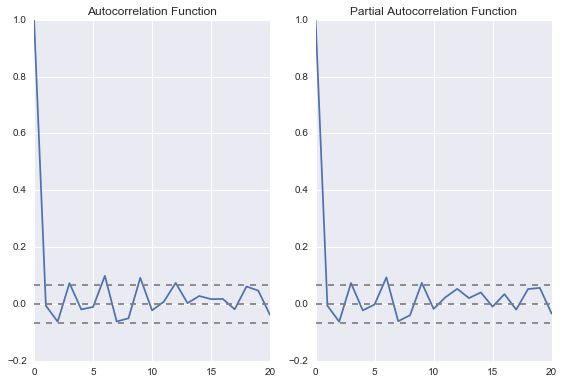

In [121]:
#Plot ACF: 
plt.figure()
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values for the ARIMA model as:

- p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=6.
- q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=6.


## ARIMA models

In [74]:
from statsmodels.tsa.arima_model import ARIMA

### AR model

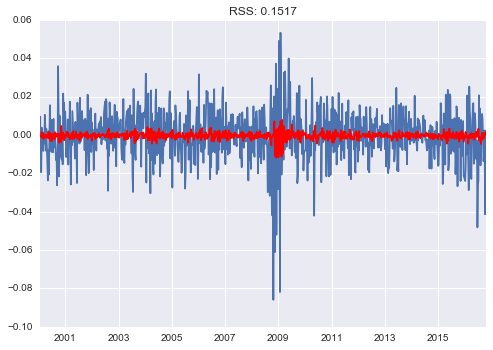

In [122]:
model = ARIMA(ts_log, order=(6, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

### MA model

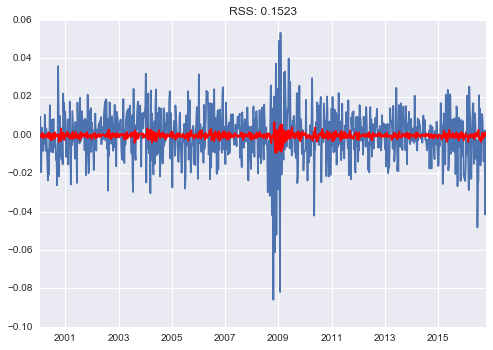

In [124]:
model = ARIMA(ts_log, order=(0, 1, 6))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

### Combined

//anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


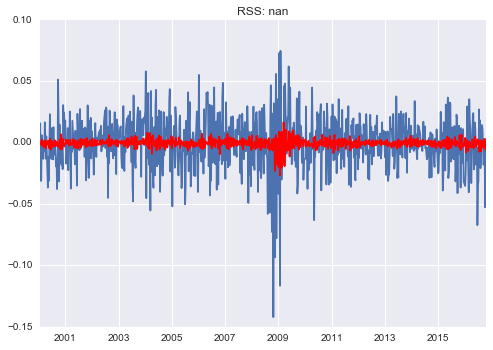

In [182]:
model = ARIMA(ts, order=(6, 1, 5))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))

In [185]:
# trend = sm.tsa.arma_order_select_ic(ts, ic=['aic', 'bic'])
model = statsmodels.tsa.arima_model.ARMA(ts_diff, trend.aic_min_order)  
results_ARMA = model.fit(disp=-1)  
plt.plot(ts_diff)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARMA.fittedvalues-ts_diff)**2))

LinAlgError: SVD did not converge

## Take it back to the original scale

In [172]:
def transform_back(results):
    predictions_diff = pd.Series(results.fittedvalues, copy=True)
    predictions_diff_cumsum = predictions_diff.cumsum()
    predictions_diff = pd.Series(ts_log.ix[0], index=ts_log.index)
    predictions_diff = predictions_diff.add(predictions_diff_cumsum,fill_value=0)
    predictions_diff_exp = np.exp(predictions_diff)
    return predictions_diff_exp

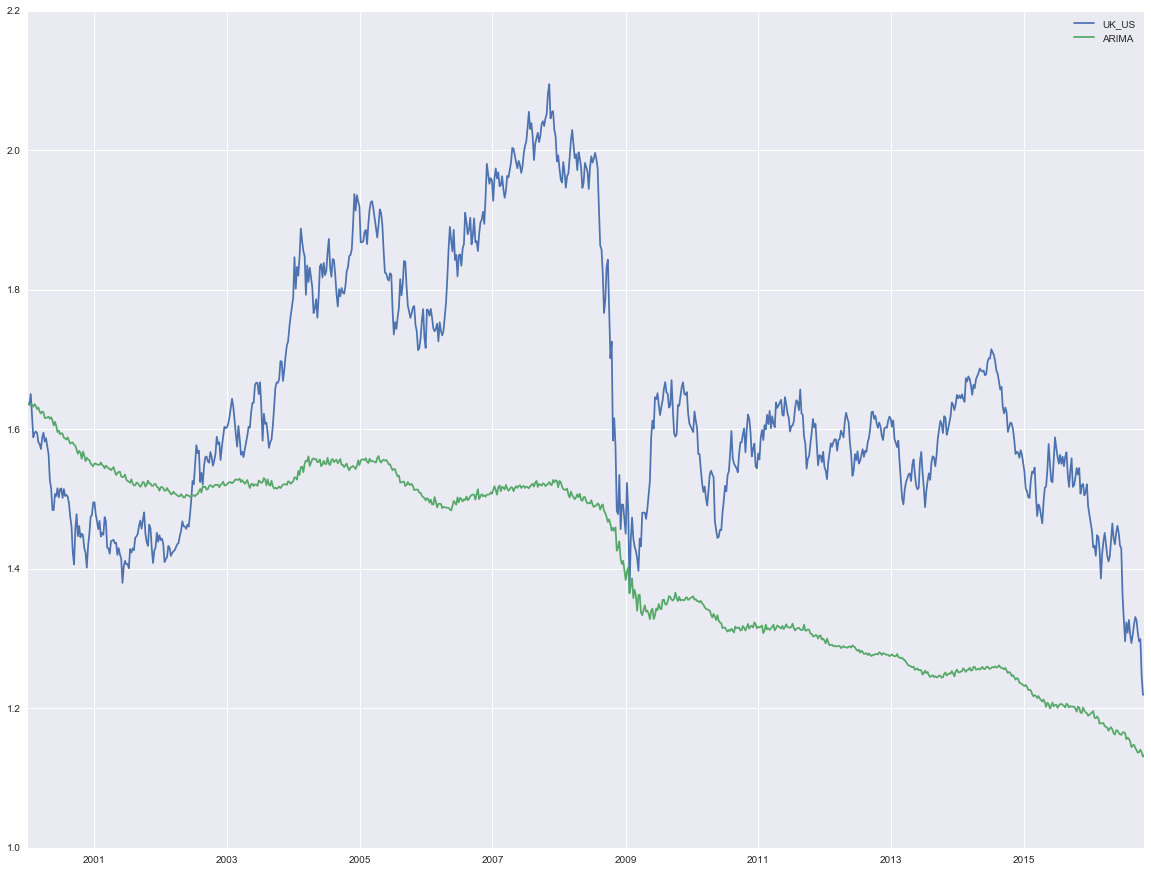

In [186]:
plt.figure(figsize=(20,15))
plt.plot(UK_US['UK_US'])
# plt.plot(transform_back(results_ARMA), label='ARMA')
plt.plot(transform_back(results_ARIMA), label='ARIMA')
# plt.plot(transform_back(results_MA), label='MA')
# plt.plot(transform_back(results_AR), label='AR')
plt.legend()
# plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_exp-UK_US['UK_US'])**2)/len(UK_US['UK_US'])))